In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df_new = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Environmental/Mouna_Loa_Weekly_Data.csv')
df_new.head()

,Year,Month,Day,Year(decimal),CO2(PPM)
0,1974,5,19,1974.3795,333.37
1,1974,5,26,1974.3986,332.95
2,1974,6,2,1974.4178,332.35
3,1974,6,9,1974.4370,332.20
4,1974,6,16,1974.4562,332.37


In [4]:
df_new.tail()

,Year,Month,Day,Year(decimal),CO2(PPM)
2472,2021,10,3,2021.7548,413.63
2473,2021,10,10,2021.7740,413.89
2474,2021,10,17,2021.7932,414.36
2475,2021,10,24,2021.8123,413.90
2476,2021,10,31,2021.8315,414.17


In [ ]:
df_new.shape

(2477, 5)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2477 entries, 0 to 2476
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           2477 non-null   int64  
 1   Month          2477 non-null   int64  
 2   Day            2477 non-null   int64  
 3   Year(decimal)  2477 non-null   float64
 4   CO2(PPM)       2477 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 96.9 KB


In [ ]:
df_new['CO2(PPM)'].min()

-999.99

In [5]:
df_new.replace(-999.99,np.nan,inplace=True)
df = df_new.fillna(df_new.rolling(7,min_periods=1).mean())

In [ ]:
df.isnull().sum()

Year             0
Month            0
Day              0
Year(decimal)    0
CO2(PPM)         0
dtype: int64

In [6]:
time = pd.date_range(start='5/19/1974',periods=2477,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Year','Month','Year(decimal)','Day'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [7]:
df.columns=['CO2_PPM']

In [ ]:
df.head()

,CO2_PPM
time_stamp,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37


In [ ]:
df.tail()

,CO2_PPM
time_stamp,
2021-10-03,413.63
2021-10-10,413.89
2021-10-17,414.36
2021-10-24,413.90
2021-10-31,414.17


In [8]:
plt.rcParams['figure.figsize'] = [15,8]

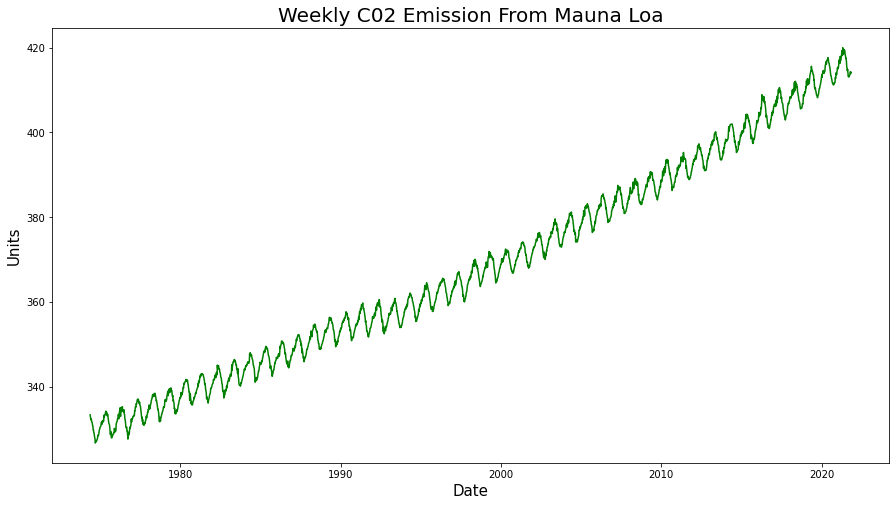

In [9]:
plt.plot(df,color='green')
plt.title('Weekly C02 Emission From Mauna Loa',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [39]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['CO2_PPM'] = df['CO2_PPM'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [40]:
#Split data set into testing dataset and train dataset
train_size = 2230
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 5
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2225, 1, 5)
(2225,)
(242, 1, 5)
(242,)


In [15]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 4.4 MB/s 


In [16]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.1,0.2,0.3],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 10 Complete [00h 01m 07s]
val_mape: 0.47922512888908386

Best val_mape So Far: 0.4684917628765106
Total elapsed time: 00h 12m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 76
first_recurrent_dropout: 0.3
dense_layer: 28
Dropout_rate: 0.0
learning_rate: 0.0007062940414508486
Score: 0.4684917628765106
Trial summary
Hyperparameters:
rnn_layer: 24
first_recurrent_dropout: 0.3
dense_layer: 80
Dropout_rate: 0.30000000000000004
learning_rate: 0.0039273683450240056
Score: 0.47922512888908386
Trial summary
Hyperparameters:
rnn_layer: 36
first_recurrent_dropout: 0.2
dense_layer: 64
Dropout_rate: 0.0
learning_rate: 0.020764742941149803
Score: 0.47985491156578064
Trial summary
Hyperparameters:
rnn_layer: 60
first_recurrent_dropout: 0.3
dense_layer: 84
Dropout_rate: 0.2
learning_rate: 0.0008218430847227947
Score: 0.494182825088501
Trial summary
Hyperparameters:
rnn_layer: 36
first_recurrent_dropout: 0.1
dense_layer: 44
Dropout_rate: 0.2
learning_rate: 0.010302251063280697
Score: 0.5000973343849182
Trial summary
Hyper

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 5))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 76)                24928     
                                                                 
 dense (Dense)               (None, 28)                2156      
                                                                 
 dropout (Dropout)           (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 27,113
Trainable params: 27,113
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [41]:
model = Sequential()
model.add(Bidirectional(LSTM(100,activation='relu',input_dim = 5)))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0002062940414508486)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 33, epochs = 200)

Epoch 1/200
68/68 [==============================] - 5s 11ms/step - loss: 81.2906 - mape: 81.2906 - val_loss: 71.2153 - val_mape: 71.2153
Epoch 2/200
68/68 [==============================] - 0s 5ms/step - loss: 47.7127 - mape: 47.7127 - val_loss: 38.5891 - val_mape: 38.5891
Epoch 3/200
68/68 [==============================] - 1s 9ms/step - loss: 16.5953 - mape: 16.5953 - val_loss: 6.6161 - val_mape: 6.6161
Epoch 4/200
68/68 [==============================] - 1s 11ms/step - loss: 8.3099 - mape: 8.3099 - val_loss: 1.0327 - val_mape: 1.0327
Epoch 5/200
68/68 [==============================] - 0s 5ms/step - loss: 5.3095 - mape: 5.3095 - val_loss: 2.8352 - val_mape: 2.8352
Epoch 6/200
68/68 [==============================] - 0s 5ms/step - loss: 3.7585 - mape: 3.7585 - val_loss: 4.1019 - val_mape: 4.1019
Epoch 7/200
68/68 [==============================] - 0s 5ms/step - loss: 3.3291 - mape: 3.3291 - val_loss: 6.6826 - val_mape: 6.6826
Epoch 8/200
68/68 [==============================] - 0s 5

In [42]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [43]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.15 
Test MAPE : 0.48 


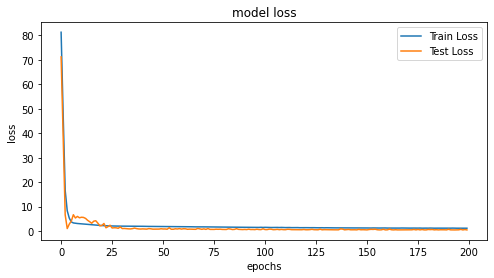

In [44]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [45]:
import seaborn as sns

In [37]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(2225,2467)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

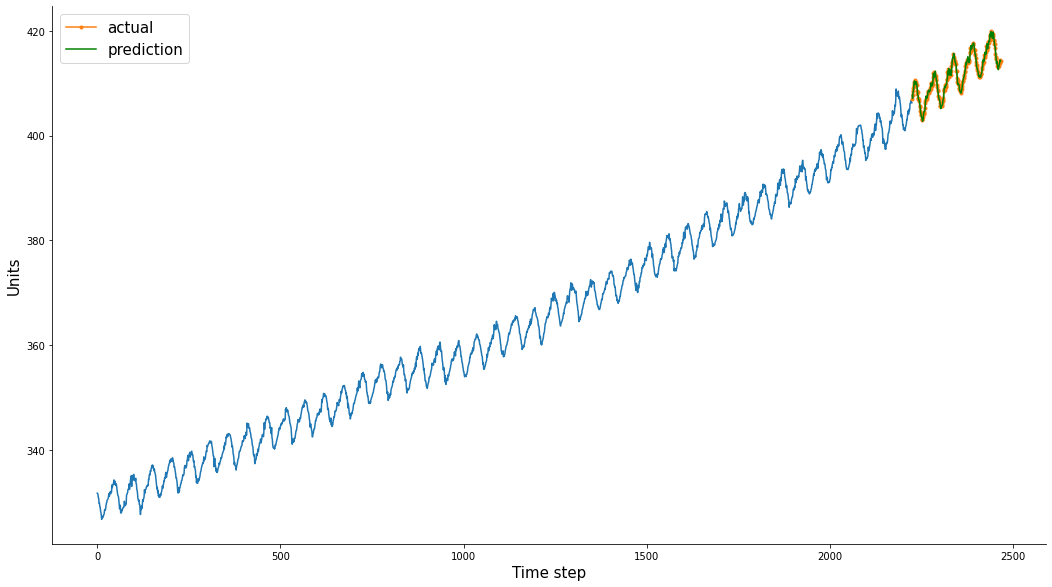

In [46]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)